<a href="https://colab.research.google.com/github/Yogesh914/emogo-ml/blob/main/gemma_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluating In-Context Learning With Gemma-7b 🦋

## Intial setup

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
!pip install transformers pydub accelerate bitsandbytes hf_transfer

In [9]:
!pip install -U transformers

In [10]:
!pip install noisereduce

In [25]:
import torch
import transformers
from IPython.display import Markdown, display
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from google.colab import userdata
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
from moviepy.editor import VideoFileClip
import numpy as np
import os
from pydub import AudioSegment
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import noisereduce as nr
import re
import json

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Transcription Using Whisper v3 (large)

In [ ]:
device = "cuda"
model_id = "openai/whisper-large-v3"

model = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_id, use_safetensors=True, torch_dtype=torch.float16, low_cpu_mem_usage=True
)
model.to(device)
processor = AutoProcessor.from_pretrained(model_id)

pipe = pipeline(
    "automatic-speech-recognition",
    model=model,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    max_new_tokens=440,
    chunk_length_s=30,
    batch_size=16,
    return_timestamps=True,
    device=device,
    torch_dtype=torch.float16
)

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.07k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
def process_video(video_file):
    if video_file.endswith('.mp4'):
        audio_segment = AudioSegment.from_file(video_file, format="mp4")
    else:
        audio_segment = AudioSegment.from_file(video_file, format="mov")
    audio_segment = audio_segment.set_frame_rate(16000)
    audio_array = np.array(audio_segment.get_array_of_samples())

    if audio_segment.channels == 2:
        audio_array = audio_array.reshape((-1, 2))
        audio_array = audio_array.mean(axis=1)
    audio_array = audio_array.astype(np.float32) / (2**15)

    audio_array = nr.reduce_noise(y=audio_array, sr=16000)

    return audio_array, audio_segment.frame_rate

In [ ]:
class AudioDataset(Dataset):
    def __init__(self, data_folder):
        self.data_folder = data_folder
        self.video_files = sorted([os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.mp4') or f.endswith('.MOV')])

    def __len__(self):
        return len(self.video_files)

    def __getitem__(self, idx):
        video_file = self.video_files[idx]
        audio_array, sample_rate = process_video(video_file)
        audio_tensor = torch.from_numpy(audio_array)
        return audio_tensor, sample_rate

In [ ]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
data_folder = '/content/drive/MyDrive/data/beta_vids'
dataset = AudioDataset(data_folder)

batch_size = 1
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

transcriptions = []
for batch in dataloader:
    audio_tensors, sample_rates = batch
    audio_tensor = audio_tensors[0]
    sample_rate = sample_rates[0].item()
    audio_numpy = audio_tensor.numpy()
    audio_dict = {"path": "audio_file", "array": audio_numpy, "sampling_rate": sample_rate}
    result = pipe(audio_dict, batch_size=1)
    transcription = result["text"]
    transcriptions.append(transcription)

df_transcriptions = pd.DataFrame({'Transcriptions': transcriptions})
df_transcriptions

,Transcriptions
0,It's 12 o'clock and I'm going to the dining h...
1,I just come back from lunch and I had steak a...
2,My class is beginning in 5 minutes and I just...
3,I just had lunch and my class will begin in f...
4,I'm right now at the dining hall and I just f...
...,...
57,I'm feeling okay because I is the meat of the...
58,I am feeling okay.
59,I feel pretty good. I have a little bit icky ...
60,I'm feeling not okay. I just have a lot to......


In [ ]:
df_transcriptions.to_csv('/content/drive/MyDrive/data/transcriptions.csv')

## Curating Dataset

In [ ]:
ema_survey = pd.read_csv(os.path.join("/content/drive/MyDrive/data/emo.csv"))
df_filtered = ema_survey[ema_survey['webscreen_id'].isin([])]
df_filtered = df_filtered[df_filtered['Trigger.Name']=="SCHEDULED EMA Trigger"]

filtered_columns = ['ema_aware', 'ema_support', 'ema_insight', 'ema_fulfilled', 'ema_hopeless', 'ema_anxious', 'webscreen_id']
df_filtered = df_filtered[filtered_columns]


df_final = df_filtered.dropna()
df_final.sort_values(by='webscreen_id', inplace=True)
df_final.reset_index(drop=True, inplace=True)

In [ ]:
df_final

,ema_aware,ema_support,ema_insight,ema_fulfilled,ema_hopeless,ema_anxious,webscreen_id
0,2.0,2.0,3.0,3.0,1.0,2.0,10052
1,4.0,1.0,1.0,4.0,1.0,1.0,10052
2,3.0,2.0,1.0,3.0,1.0,1.0,10052
3,4.0,5.0,3.0,5.0,1.0,1.0,10052
4,5.0,2.0,3.0,1.0,5.0,5.0,10052
...,...,...,...,...,...,...,...
57,2.0,4.0,4.0,4.0,2.0,3.0,10073
58,4.0,3.0,4.0,2.0,2.0,2.0,10073
59,3.0,4.0,4.0,4.0,2.0,3.0,10073
60,3.0,3.0,3.0,3.0,3.0,3.0,10073


In [ ]:
merge = pd.concat([df_transcriptions, df_final], axis=1)
merge.to_csv(os.path.join("/content/drive/MyDrive/data/merged_transcriptions.csv"), index=False)
merge

,Transcriptions,ema_aware,ema_support,ema_insight,ema_fulfilled,ema_hopeless,ema_anxious,webscreen_id
0,It's 12 o'clock and I'm going to the dining h...,2.0,2.0,3.0,3.0,1.0,2.0,10052
1,I just come back from lunch and I had steak a...,4.0,1.0,1.0,4.0,1.0,1.0,10052
2,My class is beginning in 5 minutes and I just...,3.0,2.0,1.0,3.0,1.0,1.0,10052
3,I just had lunch and my class will begin in f...,4.0,5.0,3.0,5.0,1.0,1.0,10052
4,I'm right now at the dining hall and I just f...,5.0,2.0,3.0,1.0,5.0,5.0,10052
...,...,...,...,...,...,...,...,...
57,I'm feeling okay because I is the meat of the...,2.0,4.0,4.0,4.0,2.0,3.0,10073
58,I am feeling okay.,4.0,3.0,4.0,2.0,2.0,2.0,10073
59,I feel pretty good. I have a little bit icky ...,3.0,4.0,4.0,4.0,2.0,3.0,10073
60,I'm feeling not okay. I just have a lot to......,3.0,3.0,3.0,3.0,3.0,3.0,10073


## Creating Custom Prompt

In [ ]:
df = pd.read_csv(os.path.join("/content/drive/MyDrive/data/merged_transcriptions.csv"))

def format_prompt(row):
    return f"Caption: {row['Transcriptions']}\n" \
           f"Had you noticed you were feeling this way before we asked?: {int(row['ema_aware'])}\n" \
           f"Did you feel you were supported by others?: {int(row['ema_support'])}\n" \
           f"Did you recognize how your feelings were influencing your outlook on things?: {int(row['ema_insight'])}\n" \
           f"How fulfilled did you feel?: {int(row['ema_fulfilled'])}\n" \
           f"How hopeless did you feel?: {int(row['ema_hopeless'])}\n" \
           f"How anxious did you feel?: {int(row['ema_anxious'])}"

instructions = f"\n\nBased on the previous entries, predict the ratings for the following caption on a scale of 1 to 5. Provide your answers in the following JSON format and nothing else:\n" \
               "{\n" \
               "  \"had_noticed\":,\n" \
               "  \"supported\":,\n" \
               "  \"influence\":,\n" \
               "  \"fulfilled\":,\n" \
               "  \"hopeless\":,\n" \
               "  \"anxious\":\n" \
               "}\n"

sampled_rows = df.sample(n=4)
example_rows = sampled_rows.iloc[:3]
test_row = sampled_rows.iloc[3]

prompt = "\n\n".join(example_rows.apply(format_prompt, axis=1))

last_caption = test_row.iloc[0]['Transcriptions']

prompt += f"{instructions}\n\nCaption: {last_caption}\n" \
          "Had you noticed you were feeling this way before we asked?: \n" \
          "Did you feel you were supported by others?: \n" \
          "Did you recognize how your feelings were influencing your outlook on things?: \n" \
          "How fulfilled did you feel?: \n" \
          "How hopeless did you feel?: \n" \
          "How anxious did you feel?: "

print(prompt)

Caption:  I feel alone because my roommate is not home and I have to do my homework by myself.
Had you noticed you were feeling this way before we asked?: 3
Did you feel you were supported by others?: 4
Did you recognize how your feelings were influencing your outlook on things?: 4
How fulfilled did you feel?: 3
How hopeless did you feel?: 3
How anxious did you feel?: 3

Caption:  I'm pretty good right now. I'm just studying for the exam tomorrow. Hopefully I can do well. I'm just kind of anxious about how well I'm going to do. That's pretty much it.
Had you noticed you were feeling this way before we asked?: 3
Did you feel you were supported by others?: 3
Did you recognize how your feelings were influencing your outlook on things?: 3
How fulfilled did you feel?: 3
How hopeless did you feel?: 3
How anxious did you feel?: 3

Caption:  I just took a nap. Feeling pretty good right now. Feeling pretty refreshed. Now I'm just going to start cooking dinner. Yeah, I'm not feeling bad at all. 

## Testing Gemma-7b-it

In [13]:
os.environ ['HF_HUB_ENABLE_HF_TRANSFER'] = '1'
torch.set_default_device(device)

In [14]:
quantization_config = BitsAndBytesConfig(load_in_4bit=True)

tokenizer = AutoTokenizer.from_pretrained("google/gemma-7b-it", token=userdata.get('hgemm'))

model = AutoModelForCausalLM.from_pretrained("google/gemma-7b-it",
                                             torch_dtype="auto",
                                             device_map="auto", token=userdata.get('hgemm')
                                             )

tokenizer_config.json:   0%|          | 0.00/2.16k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/888 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/2.11G [00:00<?, ?B/s]

Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [ ]:
inputs = tokenizer.encode(prompt, add_special_tokens=True, return_tensors="pt")

outputs = model.generate(input_ids=inputs.to("cuda"),
                         max_new_tokens=200)

predicted_text = tokenizer.decode(outputs[0], skip_special_tokens=True, clean_up_tokenization_spaces=True)
display(Markdown(predicted_text))

Caption:  I feel alone because my roommate is not home and I have to do my homework by myself.
Had you noticed you were feeling this way before we asked?: 3
Did you feel you were supported by others?: 4
Did you recognize how your feelings were influencing your outlook on things?: 4
How fulfilled did you feel?: 3
How hopeless did you feel?: 3
How anxious did you feel?: 3

Caption:  I'm pretty good right now. I'm just studying for the exam tomorrow. Hopefully I can do well. I'm just kind of anxious about how well I'm going to do. That's pretty much it.
Had you noticed you were feeling this way before we asked?: 3
Did you feel you were supported by others?: 3
Did you recognize how your feelings were influencing your outlook on things?: 3
How fulfilled did you feel?: 3
How hopeless did you feel?: 3
How anxious did you feel?: 3

Caption:  I just took a nap. Feeling pretty good right now. Feeling pretty refreshed. Now I'm just going to start cooking dinner. Yeah, I'm not feeling bad at all. I'm pretty good. Just kind of stressed out about homework and stuff. But it's alright.
Had you noticed you were feeling this way before we asked?: 3
Did you feel you were supported by others?: 3
Did you recognize how your feelings were influencing your outlook on things?: 4
How fulfilled did you feel?: 2
How hopeless did you feel?: 2
How anxious did you feel?: 4

Based on the previous entries, predict the ratings for the following caption on a scale of 1 to 5. Provide your answers in the following JSON format and nothing else:
{
  "had_noticed":,
  "supported":,
  "influence":,
  "fulfilled":,
  "hopeless":,
  "anxious":
}


Caption:  Feeling pretty good right now. Just had a meeting with the Wisconsin AI Safety Initiative. It was pretty good, pretty intense, but yeah, it was very thoughtful and I pretty much liked it. The leader gave me some advice on how to get internships, so I was kind of glad about that. So I'm pretty happy right now.
Had you noticed you were feeling this way before we asked?: 
Did you feel you were supported by others?: 
Did you recognize how your feelings were influencing your outlook on things?: 
How fulfilled did you feel?: 
How hopeless did you feel?: 
How anxious did you feel?: 
}

**JSON:**
```
{
  "had_noticed":?,
  "supported":?,
  "influence":?,
  "fulfilled":?,
  "hopeless":?,
  "anxious":?
}
```

**Answer:**
```
{
  "had_noticed": 3,
  "supported": 3,
  "influence": 4,
  "fulfilled": 4,
  "hopeless": 2,
  "anxious": 2
}
```

In [ ]:
predicted_json_part = predicted_text.split('**Answer:**\n```\n')[-1].strip()
predicted_json_part = predicted_json_part.split('\n```')[0].strip()
predicted_values = json.loads(predicted_json_part)

errors = {
    "had_noticed": abs(predicted_values["had_noticed"] - int(test_row['ema_aware'])),
    "supported": abs(predicted_values["supported"] - int(test_row['ema_support'])),
    "influence": abs(predicted_values["influence"] - int(test_row['ema_insight'])),
    "fulfilled": abs(predicted_values["fulfilled"] - int(test_row['ema_fulfilled'])),
    "hopeless": abs(predicted_values["hopeless"] - int(test_row['ema_hopeless'])),
    "anxious": abs(predicted_values["anxious"] - int(test_row['ema_anxious']))
}

# Calculate the average error
average_error = np.mean(list(errors.values()))

print("Predicted values:", predicted_values)
print("Actual values:", test_row.iloc[0][['ema_aware', 'ema_support', 'ema_insight', 'ema_fulfilled', 'ema_hopeless', 'ema_anxious']].to_dict())
print("Errors:", errors)
print("Average error:", average_error)

Predicted values: {'had_noticed': 3, 'supported': 3, 'influence': 4, 'fulfilled': 4, 'hopeless': 2, 'anxious': 2}
Actual values: {'ema_aware': 3.0, 'ema_support': 3.0, 'ema_insight': 3.0, 'ema_fulfilled': 2.0, 'ema_hopeless': 2.0, 'ema_anxious': 4.0}
Errors: {'had_noticed': 0, 'supported': 0, 'influence': 1, 'fulfilled': 2, 'hopeless': 0, 'anxious': 2}
Average error: 0.8333333333333334


# Testing Over Iterations 🔁

In [ ]:
error_sums = {
    "aware": 0,
    "support": 0,
    "insight": 0,
    "fulfilled": 0,
    "hopeless": 0,
    "anxious": 0
}
num_iterations = 20

In [ ]:
def make_prompt(df):
  sampled_rows = df.sample(n=4)
  example_rows = sampled_rows.iloc[:3]
  test_row = sampled_rows.iloc[3]

  prompt = "\n\n".join(example_rows.apply(format_prompt, axis=1))
  instructions = f"\n\nBased on the previous entries, predict the ratings for the following caption on a scale of 1 to 5. Provide your answers in the following JSON format and nothing else:\n" \
               "{\n" \
               "  \"aware\":,\n" \
               "  \"support\":,\n" \
               "  \"insight\":,\n" \
               "  \"fulfilled\":,\n" \
               "  \"hopeless\":,\n" \
               "  \"anxious\":\n" \
               "}\n"

  last_caption = test_row.iloc[0]['Transcriptions']

  prompt += f"{instructions}\n\nCaption: {last_caption}\n" \
            "Had you noticed you were feeling this way before we asked?: \n" \
            "Did you feel you were supported by others?: \n" \
            "Did you recognize how your feelings were influencing your outlook on things?: \n" \
            "How fulfilled did you feel?: \n" \
            "How hopeless did you feel?: \n" \
            "How anxious did you feel?: \n"

  return prompt


In [23]:
def extract_valid_json(text):
    pattern = r'\{.*?\}'
    matches = re.finditer(pattern, text, re.DOTALL)

    valid_json_objects = []

    for match in matches:
        json_str = match.group(0)

        if re.search(r'"aware":\s*\d+', json_str):
            try:
                json_data = json.loads(json_str)
                if isinstance(json_data.get("aware"), int):
                    return json_data
            except json.JSONDecodeError:
                continue

    return valid_json_objects


In [ ]:
for _ in range(num_iterations):

    prompt = make_prompt(df)

    inputs = tokenizer(prompt, return_tensors="pt", padding=True)
    outputs = model.generate(input_ids=inputs['input_ids'].to("cuda"), max_new_tokens=200)
    predicted_text = tokenizer.decode(outputs[0], skip_special_tokens=True, clean_up_tokenization_spaces=True)

    predicted_values = extract_valid_json(predicted_text)

    for key in predicted_values.keys():
        error_sums[key] += abs(predicted_values[key] - int(test_row.iloc[0]['ema_' + key]))

average_errors = {key: value / num_iterations for key, value in error_sums.items()}

overall_average_error = np.mean(list(average_errors.values()))

print("Average errors for each attribute:", average_errors)
print("Overall average error:", overall_average_error)

Average errors for each attribute: {'aware': 0.55, 'support': 0.6, 'insight': 0.7, 'fulfilled': 1.05, 'hopeless': 0.85, 'anxious': 1.9}
Overall average error: 0.9416666666666668


# Plotting 📊

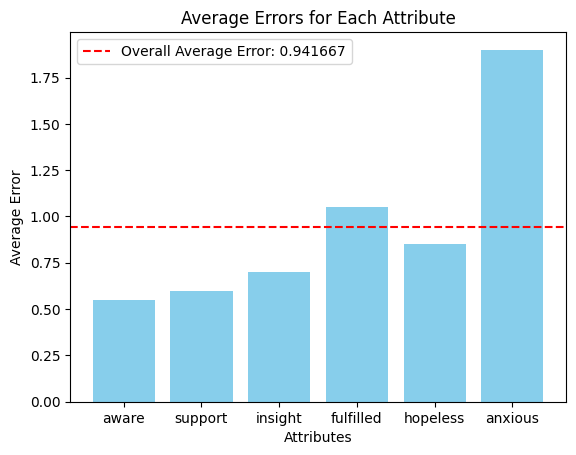

In [ ]:
import matplotlib.pyplot as plt

plt.bar(average_errors.keys(), average_errors.values(), color='skyblue')

plt.axhline(y=overall_average_error, color='red', linestyle='--', label=f'Overall Average Error: {overall_average_error:1f}')

plt.xlabel('Attributes')
plt.ylabel('Average Error')
plt.title('Average Errors for Each Attribute')

plt.legend()
plt.show()

In [15]:
import matplotlib.pyplot as plt

In [ ]:
# R squared

# Relationship Between Errors and number of Context samples provided

In [19]:
def format_prompt(row):
    return f"Caption: {row['Transcriptions']}\n" \
           f"Had you noticed you were feeling this way before we asked?: {int(row['ema_aware'])}\n" \
           f"Did you feel you were supported by others?: {int(row['ema_support'])}\n" \
           f"Did you recognize how your feelings were influencing your outlook on things?: {int(row['ema_insight'])}\n" \
           f"How fulfilled did you feel?: {int(row['ema_fulfilled'])}\n" \
           f"How hopeless did you feel?: {int(row['ema_hopeless'])}\n" \
           f"How anxious did you feel?: {int(row['ema_anxious'])}"

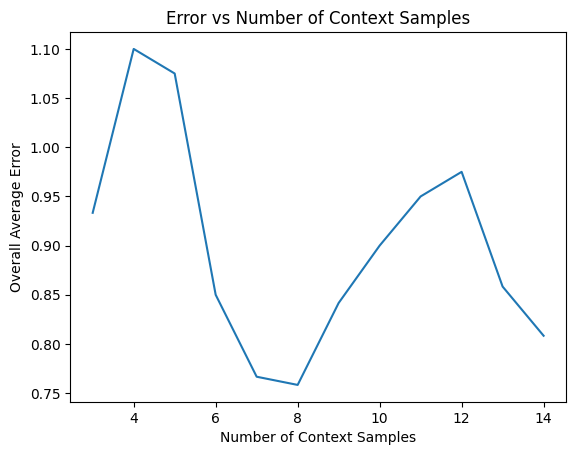

In [27]:
error_sums = {
    "aware": 0,
    "support": 0,
    "insight": 0,
    "fulfilled": 0,
    "hopeless": 0,
    "anxious": 0
}
num_iterations = 20
context_samples_range = range(3, 15)  # Adjust the range as needed

def make_prompt(df, num_context_samples):
    sampled_rows = df.sample(n=num_context_samples + 1)
    example_rows = sampled_rows.iloc[:num_context_samples]
    test_row = sampled_rows.iloc[num_context_samples]

    prompt = "\n\n".join(example_rows.apply(format_prompt, axis=1))
    instructions = f"\n\nBased on the previous entries, predict the ratings for the following caption on a scale of 1 to 5. Provide your answers in the following JSON format and nothing else:\n" \
                 "{\n" \
                 "  \"aware\":,\n" \
                 "  \"support\":,\n" \
                 "  \"insight\":,\n" \
                 "  \"fulfilled\":,\n" \
                 "  \"hopeless\":,\n" \
                 "  \"anxious\":\n" \
                 "}\n"

    last_caption = test_row['Transcriptions']

    prompt += f"{instructions}\n\nCaption: {last_caption}\n" \
              "Had you noticed you were feeling this way before we asked?: \n" \
              "Did you feel you were supported by others?: \n" \
              "Did you recognize how your feelings were influencing your outlook on things?: \n" \
              "How fulfilled did you feel?: \n" \
              "How hopeless did you feel?: \n" \
              "How anxious did you feel?: \n"

    return prompt, test_row

def calculate_errors(num_context_samples):
    error_sums = {
        "aware": 0,
        "support": 0,
        "insight": 0,
        "fulfilled": 0,
        "hopeless": 0,
        "anxious": 0
    }
    df = pd.read_csv(os.path.join("/content/drive/MyDrive/data/merged_transcriptions.csv"))

    for _ in range(num_iterations):
        prompt, test_row = make_prompt(df, num_context_samples)
        inputs = tokenizer(prompt, return_tensors="pt", padding=True)
        outputs = model.generate(input_ids=inputs['input_ids'].to("cuda"), max_new_tokens=200)
        predicted_text = tokenizer.decode(outputs[0], skip_special_tokens=True, clean_up_tokenization_spaces=True)
        predicted_values = extract_valid_json(predicted_text)

        for key in predicted_values.keys():
            error_sums[key] += abs(predicted_values[key] - int(test_row['ema_' + key]))

    average_errors = {key: value / num_iterations for key, value in error_sums.items()}
    overall_average_error = np.mean(list(average_errors.values()))

    return overall_average_error

errors_over_context_samples = []

for num_context_samples in context_samples_range:
    overall_average_error = calculate_errors(num_context_samples)
    errors_over_context_samples.append(overall_average_error)

# Plotting the errors
plt.plot(context_samples_range, errors_over_context_samples)
plt.xlabel('Number of Context Samples')
plt.ylabel('Overall Average Error')
plt.title('Error vs Number of Context Samples')
plt.show()